In [21]:
# import attrs
import numpy as np

from src.prompts.colors import color_map

invalid_color = (255, 255, 255)  # White

edge_color = (85, 85, 85)  # Grey edge color
white = (255, 255, 255)  # White

highlight_color = (255, 0, 0)  # Red


# @attrs.frozen
class RenderArgs:
    cell_size: int = 40
    use_border: bool = False
    use_larger_edges: bool = True
    use_alt_color_scheme: bool = False
    force_high_res: bool = False
    force_edge_size: int | None = None
    lower_cell_size_on_bigger_to: int | None = None
    # avoid_edge_around_border: bool = False



def create_rgb_grid(
    grid: np.ndarray,
    render_args: RenderArgs = RenderArgs(),
    should_highlight: np.ndarray | None = None,
    lower_right_triangle: np.ndarray | None = None,
):
    # this_color_scheme = alt_color_scheme
    # this_color_scheme = (
    #     alt_color_scheme if render_args.use_alt_color_scheme else color_scheme
    # )

    height, width = grid.shape

    cell_size = render_args.cell_size
    use_border = render_args.use_border
    use_larger_edges = render_args.use_larger_edges
    force_edge_size = render_args.force_edge_size
    # avoid_edge_around_border = render_args.avoid_edge_around_border

    if render_args.lower_cell_size_on_bigger_to is not None and (
        height > 10 or width > 10
    ):
        cell_size = render_args.lower_cell_size_on_bigger_to

    if force_edge_size is not None:
        edge_size = force_edge_size
    else:
        edge_size = max(cell_size // 8, 1) if use_larger_edges else 1

    # Calculate the size of the new grid with edges
    new_height = height * (cell_size + edge_size) + edge_size
    new_width = width * (cell_size + edge_size) + edge_size

    # Create a new grid filled with the edge color
    rgb_grid = np.full((new_height, new_width, 3), edge_color, dtype=np.uint8)

    # Fill in the cells with the appropriate colors
    for i in range(height):
        for j in range(width):
            color = color_map[grid[i, j]].rgb
            start_row = i * (cell_size + edge_size) + edge_size
            start_col = j * (cell_size + edge_size) + edge_size

            if should_highlight is not None and should_highlight[i, j]:
                rgb_grid[
                    start_row : start_row + cell_size, start_col : start_col + cell_size
                ] = highlight_color
                highlight_width = cell_size // 8
                rgb_grid[
                    start_row + highlight_width : start_row
                    + cell_size
                    - highlight_width,
                    start_col + highlight_width : start_col
                    + cell_size
                    - highlight_width,
                ] = color

                assert (
                    lower_right_triangle is None
                ), "Can't highlight and lower right triangle at the same time (yet)"

            else:
                rgb_grid[
                    start_row : start_row + cell_size, start_col : start_col + cell_size
                ] = color

                if lower_right_triangle is not None:
                    lower_right_triangle_color = color_map[
                        lower_right_triangle[i, j]
                    ].rgb
                    for r in range(cell_size):
                        for c in range(cell_size):
                            if r > c:
                                rgb_grid[
                                    start_row + r, start_col + cell_size - 1 - c
                                ] = lower_right_triangle_color

    # if avoid_edge_around_border:
    #     return rgb_grid[
    #         edge_size : new_height - edge_size, edge_size : new_width - edge_size
    #     ]

    if not use_border:
        return rgb_grid

    rgb_grid_border = np.full(
        (new_height + cell_size, new_width + cell_size, 3), white, dtype=np.uint8
    )
    assert cell_size % 2 == 0
    rgb_grid_border[
        cell_size // 2 : new_height + cell_size // 2,
        cell_size // 2 : new_width + cell_size // 2,
    ] = rgb_grid

    return rgb_grid_border



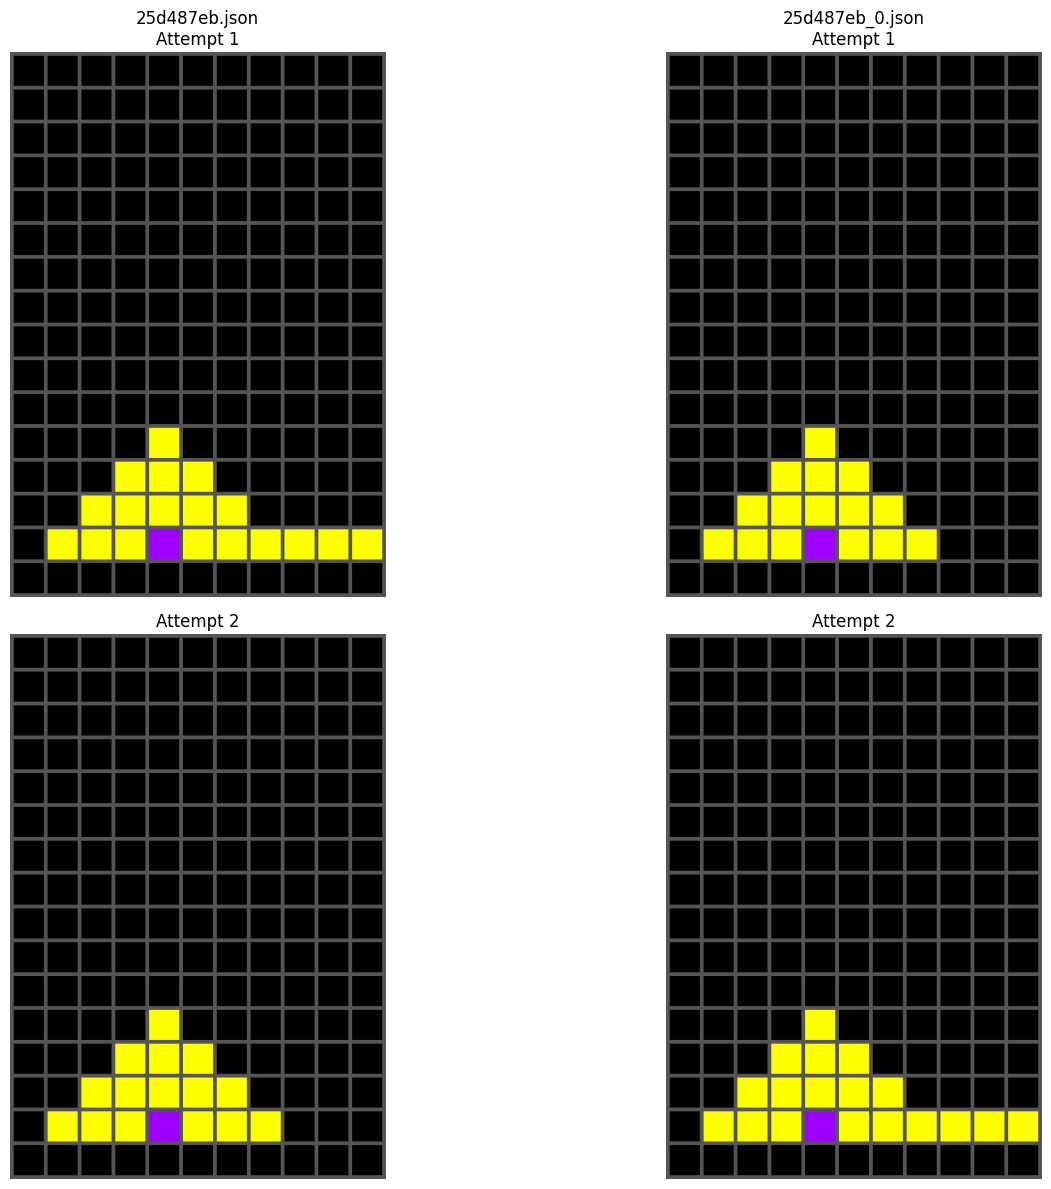

In [36]:
import matplotlib.pyplot as plt
import json
import glob
import os

# Get all json files in the directory
json_files = glob.glob("test_data_mine/tmp_solutions/*.json")

# Create a figure with subplots for each JSON file
fig, axes = plt.subplots(2, len(json_files), figsize=(8 * len(json_files), 12))

# If there's only one JSON file, wrap axes in a list to make it 2D
if len(json_files) == 1:
    axes = axes.reshape(2, 1)

# Iterate through each JSON file
for file_idx, json_file in enumerate(json_files):
    # Load the JSON data
    with open(json_file, "r") as f:
        initial_values = json.load(f)
    
    # Create visualizations for both attempts
    attempt_1 = np.array(initial_values[0]["attempt_1"])
    attempt_2 = np.array(initial_values[0]["attempt_2"])
    
    rgb_grid_attempt_1 = create_rgb_grid(attempt_1)
    rgb_grid_attempt_2 = create_rgb_grid(attempt_2)
    
    # Display attempts vertically for this JSON file
    file_name = os.path.basename(json_file)
    axes[0, file_idx].imshow(rgb_grid_attempt_1)
    axes[0, file_idx].axis('off')
    axes[0, file_idx].set_title(f'{file_name}\nAttempt 1')
    
    axes[1, file_idx].imshow(rgb_grid_attempt_2)
    axes[1, file_idx].axis('off')
    axes[1, file_idx].set_title('Attempt 2')

plt.tight_layout()
plt.show()

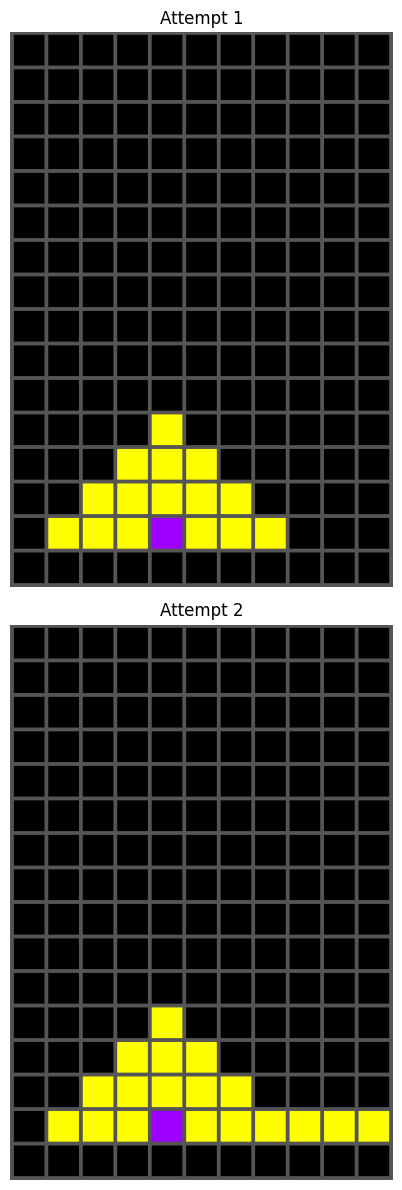

In [35]:
import matplotlib.pyplot as plt
import json
# load initial values from json file


with open("test_data_mine/tmp_solutions/25d487eb_0.json", "r") as f:
    initial_values = json.load(f)

attempt_1 = np.array(initial_values[0]["attempt_1"])
attempt_2 = np.array(initial_values[0]["attempt_2"])
# attempt_1
rgb_grid_attempt_1 = create_rgb_grid(
    attempt_1,
    # cell_size=10,
)
rgb_grid_attempt_2 = create_rgb_grid(
    attempt_2,
    # cell_size=10,
)


# show both images side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))

# Display the first image in the top subplot
ax1.imshow(rgb_grid_attempt_1)
ax1.axis('off')
ax1.set_title('Attempt 1')

# Display the second image in the bottom subplot
ax2.imshow(rgb_grid_attempt_2)
ax2.axis('off')
ax2.set_title('Attempt 2')

plt.tight_layout()
plt.show()
